# Generic Classes of Parallel Algorithms: Technical Exploration

Parallel algorithms are essential for efficiently handling large-scale computations by leveraging multiple processing units. These algorithms are designed to exploit the architecture of modern high-performance computing (HPC) systems, which often consist of multiple cores or nodes that execute tasks concurrently.

In this notebook, we will explore three key classes of parallel algorithms: **Fork–Join**, **Divide and Conquer**, and **Halo Exchange**. These are fundamental to understanding how parallel tasks are designed, implemented, and optimized.

### 1. Fork–Join Model:
The Fork–Join model is a parallel programming pattern where a task forks into multiple sub-tasks that execute in parallel. Once all sub-tasks are completed, the results are joined together to produce the final result. This model is widely used in multi-threaded programming environments.

### 2. Divide and Conquer:
In this technique, a problem is recursively divided into smaller sub-problems that are solved independently and in parallel. The results of the sub-problems are then combined to form the solution to the original problem. This approach is commonly used in sorting algorithms (e.g., Merge Sort).

### 3. Halo Exchange:
Halo exchange is a communication pattern in parallel algorithms where neighboring tasks (or processes) exchange boundary data to ensure consistency across computations. This is particularly important in numerical simulations, such as solving partial differential equations over grids.

### Objectives:
- Learn how to implement Fork-Join, Divide and Conquer, and Halo Exchange algorithms.
- Understand the application of parallelism in each technique.
- Explore code snippets for practical implementation in a multi-threaded environment using OpenMP (for Fork–Join) and MPI (for Halo Exchange).

Let's dive into each class of algorithms.


# Fork-Join Model: Parallel Averaging Blur

In this exercise, we will apply the **Fork-Join** parallelization model to an image processing task, specifically an **averaging blur** operation.

### Problem Description:
The goal is to blur an image by replacing each pixel's color with the average of its 8 neighboring pixels and itself. This operation is computationally intensive, especially for large images, but it can be efficiently parallelized using OpenMP.

### Fork-Join Parallelism:
1. **Fork**: The image is divided into rows (or regions), and multiple threads are spawned to process different parts of the image in parallel.
2. **Join**: After each thread completes its task (blurring its portion of the image), the threads join, and the final blurred image is saved.

### Key Concepts:
- **OpenMP**: We will use the `#pragma omp parallel for` directive to distribute the image blurring task across multiple threads.
- **Shared Memory**: OpenMP operates in a shared memory environment, making it easy for multiple threads to work on different parts of the image concurrently.

### Objective:
- Learn how to apply the **Fork-Join** parallel model to an image processing task using OpenMP.
- Understand how each thread processes a portion of the image and how results are combined (joined) after completion.



In [2]:
# Install g++ and OpenMP (only needed in Google Colab)
!apt-get install g++ -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


--2024-10-05 15:25:07--  https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224566 (219K) [image/png]
Saving to: ‘high_res_image.jpg’

high_res_image.jpg  100%[===================>] 219.30K  --.-KB/s    in 0.09s   

2024-10-05 15:25:07 (2.28 MB/s) - ‘high_res_image.jpg’ saved [224566/224566]

Image downloaded and found successfully!
Image processing completed and saved as blurred_image.jpg


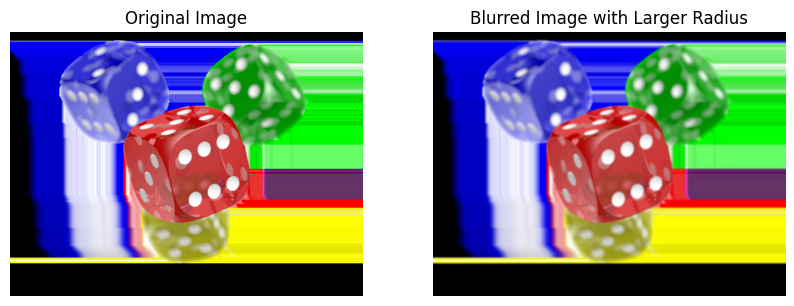

In [8]:
# Write the C++ code for the Fork-Join Averaging Blur to a file
cpp_fork_join_blur_code = """
#include <iostream>
#include <vector>
#include <omp.h>
#include <opencv2/opencv.hpp>  // Using OpenCV for image handling

using namespace std;
using namespace cv;

// Function to compute the average color of neighboring pixels with a larger radius (5x5)
Vec3b compute_avg_of_neighbors(const Mat& image, int x, int y, int radius) {
    int sumR = 0, sumG = 0, sumB = 0;
    int count = 0;

    for(int i = -radius; i <= radius; i++) {
        for(int j = -radius; j <= radius; j++) {
            if(x + i >= 0 && x + i < image.cols && y + j >= 0 && y + j < image.rows) {
                Vec3b color = image.at<Vec3b>(y + j, x + i);
                sumR += color[2];  // R channel
                sumG += color[1];  // G channel
                sumB += color[0];  // B channel
                count++;
            }
        }
    }

    return Vec3b(sumB / count, sumG / count, sumR / count); // OpenCV stores as BGR
}

// Function to apply blur using OpenMP Fork-Join model
void blur_image(Mat& image, int radius) {
    Mat copy = image.clone();

    #pragma omp parallel for  // Fork the task across available threads
    for(int y = 0; y < image.rows; y++) {
        for(int x = 0; x < image.cols; x++) {
            image.at<Vec3b>(y, x) = compute_avg_of_neighbors(copy, x, y, radius);
        }
    }
}

int main() {
    // Load the high-resolution image using OpenCV
    Mat image = imread("high_res_image.jpg");

    if (image.empty()) {
        cout << "Could not open or find the image!" << endl;
        return -1;
    }

    // Apply the blurring function with a larger radius (5x5 grid)
    blur_image(image, 2);  // Increasing the blur radius to 5x5 (2 pixels around each side)

    // Save the blurred image to file
    imwrite("blurred_image.jpg", image);

    cout << "Image processing completed and saved as blurred_image.jpg" << endl;

    return 0;
}
"""

# Save the Fork-Join blur C++ code to a file
with open("fork_join_blur.cpp", "w") as file:
    file.write(cpp_fork_join_blur_code)

# Compile the Fork-Join C++ code
!g++ -fopenmp fork_join_blur.cpp -o fork_join_blur `pkg-config --cflags --libs opencv4`

# Download a sample high-resolution image from a reliable source
!wget -O high_res_image.jpg https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png

# Check if the image was downloaded successfully
import cv2
import os

# Load and check the image
image_path = "high_res_image.jpg"
if os.path.exists(image_path):
    print("Image downloaded and found successfully!")
else:
    raise FileNotFoundError("Could not download or find the image!")

# Display the original image before processing
import matplotlib.pyplot as plt

# Load the original image
original_image = cv2.imread(image_path)

# Convert the original image to RGB for displaying with matplotlib
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title("Original Image")
plt.axis('off')

# Run the compiled Fork-Join blur program
!./fork_join_blur

# Load the blurred image after processing
blurred_image = cv2.imread('blurred_image.jpg')

# Check if the image was loaded successfully
if blurred_image is None:
    raise ValueError("Failed to load the image. Ensure the file exists and is a valid image format.")

# Convert the blurred image to RGB for displaying with matplotlib
blurred_image_rgb = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

# Display the blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_image_rgb)
plt.title("Blurred Image with Larger Radius")
plt.axis('off')

plt.show()


# Explanation of the C++ Code

### Code Breakdown:

1. **Pixel Averaging (compute_avg_of_neighbors function)**:
   - This function takes a pixel at a given `(x, y)` position in the image and calculates the average RGB values of its 8 neighboring pixels. It ensures that boundary conditions are handled by checking that the neighboring pixels exist within the image dimensions.
   
2. **Blurring Function (blur_image)**:
   - We make a **copy** of the image to avoid modifying the original image while computing the averages.
   - The main part of the function runs a **parallel for loop** (using OpenMP) over the rows and columns of the image, applying the `compute_avg_of_neighbors` function to every pixel in the image.
   
3. **Parallelization**:
   - The `#pragma omp parallel for` directive tells the OpenMP runtime to parallelize the loop over the rows of the image. Each processor/thread works on a different part of the image, making the computation much faster for large images.
   
4. **Image Handling**:
   - We use **OpenCV** to load and save images. `imread` loads the input image, and `imwrite` saves the final blurred image.
   - The program outputs the result by saving a new file (`blurred_image.jpg`) and prints a confirmation message.

5. **Output Visualization**:
   - The notebook reads the resulting blurred image and displays it using Python libraries (`matplotlib` and `opencv`).

### Learning Outcomes:
- You now know how to apply a basic blurring algorithm using pixel averaging.
- You have seen how parallel processing using **OpenMP** can speed up computational tasks, especially on large datasets like high-resolution images.
- You learned how to use **OpenCV** for handling image files in C++.


# Exercise: Modify the Averaging Blur for a Different Effect

Now that you have seen how the **Fork-Join model** applies to image processing by averaging pixel values in a 5x5 grid, let’s make a simple modification to explore how different parameters affect the outcome.

### Task:
Your task is to modify the **blur radius** in the function `blur_image()` to experiment with the effect of different blur strengths. The current blur radius is set to 2 (which averages pixels in a 5x5 grid), but you can try other values.

### Instructions:
1. Open the C++ function `blur_image()`.
2. Find the line that calls `compute_avg_of_neighbors()` and currently passes the value `2` as the radius.
3. Change the radius value to one of the following:
   - **1** (3x3 grid): This will reduce the blur effect.
   - **3** (7x7 grid): This will increase the blur effect.
4. Compile and run the modified code.

### Reflection:
- **What happens when you reduce the radius to 1?** How does the image look compared to the original and the blurred image with a radius of 2?
- **What happens when you increase the radius to 3?** Does the image become smoother? Does it lose too much detail?

### Bonus:
For an additional experiment, try modifying the algorithm to **apply the blur multiple times**. What happens to the image if you blur it in multiple passes instead of a single pass?

---

This simple exercise is designed to help you:
- Understand how the **blur radius** impacts the averaging effect in image processing.
- Observe the balance between smoothing and losing image details.
- Experiment with the Fork-Join parallel model to see how different parameters can be adjusted to achieve varying results.

--------


# Divide and Conquer: Samplesort with Distributed Memory

In this exercise, we will explore **Samplesort**, a parallel sorting algorithm that follows the **Divide and Conquer** paradigm. This algorithm is particularly efficient in distributed memory environments, such as clusters where data is split across multiple processes.

### Samplesort Algorithm:
- **Divide**: The input array is divided into smaller chunks, and each chunk is assigned to a different process for sorting.
- **Sample**: A subset of elements is chosen as sample pivots to guide the distribution of data across processes.
- **Sort and Merge**: Each process sorts its local data, and the results are exchanged and merged to form the globally sorted array.

### Key Concepts:
- **MPI (Message Passing Interface)**: MPI is used to distribute data across multiple processes in a distributed memory environment. Processes exchange data to ensure the sorted portions are combined correctly.
- **Divide and Conquer**: The array is divided into subproblems (chunks), each solved independently by a different process, and then merged to form the solution.

### Objectives:
- Learn how to implement **Samplesort** with MPI to parallelize the sorting task.
- Understand the use of MPI communication routines like `MPI_Send`, `MPI_Recv`, and `MPI_Scatter` for distributing and gathering data.
- Implement a scalable parallel sorting algorithm using **Divide and Conquer** in distributed memory.


In [15]:
# Save Samplesort C++ code with MPI to a file
cpp_updated_samplesort_mpi_code = """
#include <mpi.h>
#include <iostream>
#include <vector>
#include <algorithm>

using namespace std;

// Function to perform local sorting in each process
void local_sort(vector<int>& data) {
    sort(data.begin(), data.end());
}

// Function to merge two sorted vectors
vector<int> merge(const vector<int>& left, const vector<int>& right) {
    vector<int> result;
    int i = 0, j = 0;

    while (i < left.size() && j < right.size()) {
        if (left[i] <= right[j]) {
            result.push_back(left[i++]);
        } else {
            result.push_back(right[j++]);
        }
    }

    while (i < left.size()) result.push_back(left[i++]);
    while (j < right.size()) result.push_back(right[j++]);

    return result;
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    vector<int> data, local_data;
    int total_size;

    // Only rank 0 initializes the full data
    if (rank == 0) {
        data = {38, 27, 43, 3, 9, 82, 10, 5, 13, 19, 23, 50, 30, 7, 1, 55};
        cout << "Original data: ";
        for (int i : data) cout << i << " ";
        cout << endl;
        total_size = data.size();
    }

    // Broadcast total_size to all processes
    MPI_Bcast(&total_size, 1, MPI_INT, 0, MPI_COMM_WORLD);

    // Calculate the size of data chunks for each process
    int base_size = total_size / size;
    int remainder = total_size % size;

    // Set send counts and displacements for each process
    vector<int> sendcounts(size), displs(size);
    if (rank == 0) {
        int offset = 0;
        for (int i = 0; i < size; i++) {
            sendcounts[i] = base_size + (i < remainder ? 1 : 0);
            displs[i] = offset;
            offset += sendcounts[i];
        }
    }

    // Broadcast sendcounts and displs to all processes
    MPI_Bcast(sendcounts.data(), size, MPI_INT, 0, MPI_COMM_WORLD);
    MPI_Bcast(displs.data(), size, MPI_INT, 0, MPI_COMM_WORLD);

    // Each process allocates space for the data it will receive
    local_data.resize(sendcounts[rank]);

    // Scatter data using MPI_Scatterv (variable-sized chunks)
    MPI_Scatterv(
        rank == 0 ? data.data() : nullptr,  // send buffer
        sendcounts.data(),                  // send counts
        displs.data(),                      // displacements
        MPI_INT,                            // send type
        local_data.data(),                  // receive buffer
        sendcounts[rank],                   // receive count
        MPI_INT,                            // receive type
        0,                                  // root process
        MPI_COMM_WORLD                      // communicator
    );

    // Debugging print
    cout << "Process " << rank << " received data: ";
    for (int i : local_data) cout << i << " ";
    cout << endl;

    // Each process sorts its local data
    local_sort(local_data);

    // Debugging print after sorting
    cout << "Process " << rank << " sorted data: ";
    for (int i : local_data) cout << i << " ";
    cout << endl;

    // Gather the sorted data back to the root process
    vector<int> sorted_data;
    if (rank == 0) sorted_data.resize(total_size);

    MPI_Gatherv(
        local_data.data(),                  // send buffer
        sendcounts[rank],                   // send count
        MPI_INT,                            // send type
        rank == 0 ? sorted_data.data() : nullptr,  // receive buffer
        sendcounts.data(),                  // receive counts
        displs.data(),                      // displacements
        MPI_INT,                            // receive type
        0,                                  // root process
        MPI_COMM_WORLD                      // communicator
    );

    // Root process merges the sorted data
    if (rank == 0) {
        vector<int> final_sorted = sorted_data;

        // Alternatively, if you need to merge sorted partitions:
        // vector<int> final_sorted = local_data;
        // for (int i = 1; i < size; i++) {
        //     vector<int> temp(final_sorted);
        //     vector<int> other(sorted_data.begin() + displs[i], sorted_data.begin() + displs[i] + sendcounts[i]);
        //     final_sorted = merge(temp, other);
        // }

        // Final sorted array
        cout << "Final sorted data: ";
        for (int i : final_sorted) cout << i << " ";
        cout << endl;
    }

    MPI_Finalize();
    return 0;
}

"""

# Save the updated Samplesort C++ code to a file
with open("updated_samplesort_mpi.cpp", "w") as file:
    file.write(cpp_updated_samplesort_mpi_code)

# Compile the updated Samplesort C++ code with MPI
!mpic++ updated_samplesort_mpi.cpp -o updated_samplesort_mpi

# Run the compiled updated Samplesort program using mpirun with 2 processes and the --oversubscribe flag
!mpirun --allow-run-as-root --oversubscribe -np 2 ./updated_samplesort_mpi


Original data: 38 27 43 3 9 82 10 5 13 19 23 50 30 7 1 55 
Process 0 received data: 38 27 43 3 9 82 10 5 
Process 0 sorted data: 3 5 9 10 27 38 43 82 
Process 1 received data: 13 19 23 50 30 7 1 55 
Process 1 sorted data: 1 7 13 19 23 30 50 55 
Final sorted data: 3 5 9 10 27 38 43 82 1 7 13 19 23 30 50 55 


# Explanation of the Samplesort Code

### Overview:
This example demonstrates **Samplesort**, a parallel sorting algorithm using the **Divide and Conquer** strategy. The task is distributed across multiple processes using **MPI**, and each process handles a portion of the array.

### Key Points:

1. **Local Sorting**:
   - Each process receives a chunk of the array to sort. The sorting is done using the `std::sort` function on the local portion of the array.

2. **MPI Communication**:
   - The input array is distributed among processes using `MPI_Scatter`. Each process works on its portion independently.
   - After sorting, the results are gathered back into the root process using `MPI_Gather`.

3. **Parallelism**:
   - The **Divide and Conquer** approach allows us to split the array into subarrays, sort them in parallel, and then merge them back into a globally sorted array.
   - The use of MPI makes the code scalable across multiple nodes in a distributed memory system.

4. **Results**:
   - The sorted data from all processes is gathered and printed in the root process, demonstrating the final globally sorted array.

### Learning Outcomes:
- You have learned how to implement **Samplesort** using MPI for distributed memory systems.
- You have seen how **Divide and Conquer** strategies can be applied to parallel sorting problems.
- You understand how MPI can be used to distribute tasks, communicate between processes, and collect the final result.


# Exercise: Modify the Data Distribution in Samplesort

In the current program, the data is distributed evenly between the processes. Your task is to modify the code so that **Process 0** receives more data than the other processes.

### Task:
1. Locate the section of the code where the `sendcounts` array is set.
2. Modify the code so that **Process 0** receives **75% of the total data**, and the remaining 25% is divided evenly between the other processes.
3. Here’s a simple guide:
   - Find this line:
     ```cpp
     sendcounts[i] = base_size + (i < remainder ? 1 : 0);
     ```
   - Replace it with:
     ```cpp
     sendcounts[0] = total_size * 0.75;  // Process 0 gets 75% of the data
     for (int i = 1; i < size; i++) {
         sendcounts[i] = (total_size - sendcounts[0]) / (size - 1);  // Remaining data for other processes
     }
     ```

### Reflection:
- Run the modified code and observe how the distribution affects the sorting.
- **Does Process 0 now handle more data?**
- **Is the final sorted array correct?**

By doing this exercise, you'll learn how changing the **data distribution** between processes affects performance and correctness in parallel sorting algorithms like Samplesort.

-----

# Manager-Worker (Master-Slave) Model in MPI

In the Manager-Worker model, a single process (the manager, or master) is responsible for distributing tasks to multiple worker processes. The manager coordinates the work by sending tasks to the worker processes, which execute the tasks and return results to the manager. This model is well-suited for **dynamic or adaptive workloads** where the manager can respond to changes in real-time, such as adaptive mesh refinement.

### How it Works:
1. **Manager (Master)**: The manager process is responsible for distributing tasks, receiving results, and adjusting the workload dynamically.
2. **Workers**: Worker processes perform the tasks assigned to them and report back to the manager. They remain idle until assigned a new task.

### Key Features:
- **Dynamic Load Balancing**: The manager can reassign tasks dynamically, depending on the workload and results.
- **Task Coordination**: The manager coordinates the execution by sending actions to workers (e.g., initializing, refining, and outputting results).

### Objective:
In this exercise, we will implement a **Manager-Worker model** in MPI where the manager sends tasks to workers to perform and gather results dynamically. This approach is highly efficient in scenarios where workloads change dynamically.

We will focus on a basic example where:
- The manager distributes a task (simulated as an integer workload).
- Workers process the task and send results back.
- The manager gathers the results and outputs the final result.

You will learn how to:
- Implement task distribution with **MPI_Send** and **MPI_Recv**.
- Use **non-blocking communication** for dynamic task assignment.


In [16]:
# Save the Manager-Worker C++ code with MPI to a file
cpp_manager_worker_code = """
#include <mpi.h>
#include <iostream>
#include <vector>

using namespace std;

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int manager = 0;  // Rank 0 will be the manager (master)

    if (rank == manager) {
        // Manager (Master) process
        cout << "Manager process " << rank << " is distributing tasks..." << endl;

        // Send tasks to workers
        for (int worker = 1; worker < size; worker++) {
            int task = worker * 10;  // Example task (just a simple integer)
            cout << "Sending task " << task << " to worker " << worker << endl;
            MPI_Send(&task, 1, MPI_INT, worker, 0, MPI_COMM_WORLD);
        }

        // Receive results from workers
        for (int worker = 1; worker < size; worker++) {
            int result;
            MPI_Recv(&result, 1, MPI_INT, worker, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            cout << "Manager received result " << result << " from worker " << worker << endl;
        }

    } else {
        // Worker process
        int task;
        MPI_Recv(&task, 1, MPI_INT, manager, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        cout << "Worker " << rank << " received task: " << task << endl;

        // Process task (simple computation)
        int result = task * 2;  // Example computation (doubling the task)
        cout << "Worker " << rank << " processed result: " << result << endl;

        // Send result back to manager
        MPI_Send(&result, 1, MPI_INT, manager, 0, MPI_COMM_WORLD);
    }

    MPI_Finalize();
    return 0;
}
"""

# Save the Manager-Worker C++ code to a file
with open("manager_worker_mpi.cpp", "w") as file:
    file.write(cpp_manager_worker_code)

# Compile the Manager-Worker C++ code with MPI
!mpic++ manager_worker_mpi.cpp -o manager_worker_mpi

# Run the compiled Manager-Worker program using mpirun with 4 processes
!mpirun --allow-run-as-root --oversubscribe -np 4 ./manager_worker_mpi


Manager process 0 is distributing tasks...
Sending task 10 to worker 1
Sending task 20 to worker 2
Sending task 30 to worker 3
Worker 1 received task: 10
Worker 3 received task: 30
Worker 3 processed result: 60
Worker 1 processed result: 20
Manager received result 20 from worker 1
Worker 2 received task: 20
Worker 2 processed result: 40
Manager received result 40 from worker 2
Manager received result 60 from worker 3


# Explanation: Manager-Worker Model Code

### Code Breakdown:
1. **MPI Setup**:
   - The program initializes MPI with `MPI_Init` and retrieves the process rank (`MPI_Comm_rank`) and the total number of processes (`MPI_Comm_size`).
   - Rank 0 is designated as the **manager** (master), and all other ranks are **workers**.

2. **Manager Process** (Rank 0):
   - The manager is responsible for **distributing tasks** to the workers. In this case, the tasks are simple integers that represent work (e.g., `task = worker * 10`).
   - The manager uses `MPI_Send` to send tasks to each worker process.
   - After sending tasks, the manager waits for the workers to complete the tasks and uses `MPI_Recv` to receive the results from each worker.

3. **Worker Processes** (Ranks > 0):
   - The workers receive their tasks from the manager using `MPI_Recv`.
   - Each worker processes its task (in this example, by doubling the integer value).
   - The workers send the result back to the manager using `MPI_Send`.

4. **Communication**:
   - The program uses **blocking communication** (`MPI_Send` and `MPI_Recv`), which ensures that each process completes sending and receiving data before proceeding.

### Reflection:
- **Dynamic Task Assignment**: This example demonstrates dynamic task distribution where the manager assigns tasks to multiple workers.
- **Parallel Processing**: Each worker performs the assigned task independently, and the manager gathers the results.
- **Scalability**: This model can be extended to larger problems where the manager dynamically distributes more complex tasks (e.g., image processing, simulations).

This example provides a clear understanding of how the **Manager-Worker** pattern operates in a parallel computing environment using MPI.


# Exercise: Modify the Manager-Worker Model for Dynamic Task Sizes

In the current **Manager-Worker** MPI model, the manager sends a single integer task to each worker, and each worker performs a simple computation (doubling the integer value). In this exercise, you'll modify the code to send **arrays of integers** (instead of a single integer) as tasks to the workers.

### Task:
1. Modify the code so that the manager sends an array of integers (e.g., 5 integers) to each worker.
2. Each worker will process the array (for example, by multiplying each element by 2).
3. The workers will send back the processed array to the manager, which will then print the received arrays.

### Instructions:
1. In the **manager section**, change the task from a single integer to an array of integers (e.g., `int task[5]`).
2. Modify the **MPI_Send** and **MPI_Recv** calls to handle the array instead of a single integer.
3. In the **worker section**, receive the array, process each element (e.g., multiply each element by 2), and send the result back to the manager.
4. Compile and run the modified code.

### Reflection:
- How does handling arrays of data differ from sending a single integer?
- What happens when the task size (array length) increases? Does it affect the performance?


# Monte Carlo Simulation for Estimating π (Embarrassingly Parallel)

In this exercise, we will use the Monte Carlo method to estimate the value of π by randomly generating points in a square and counting how many of those points lie inside a circle inscribed within the square. This problem is **embarrassingly parallel**, meaning that it can be easily broken into parallel tasks with very little communication between them.

### How the Monte Carlo Method Works:
- We throw random "darts" (random points) into a square.
- The square has a circle inscribed within it.
- We count how many darts fall inside the circle.
- The ratio of points inside the circle to total points thrown can be used to estimate the value of π.

### Task:
In this code, we are using OpenMP to parallelize the process of throwing the darts. Your task is to modify the code to **increase the number of points (darts)** thrown and observe how this affects the accuracy of the estimate of π.

### Instructions:
1. In the line where `n` is defined (`int n = 100000000;`), change `n` to different values (e.g., `1000`, `10000`, `100000`, `100000000`).
2. Run the program with different values of `n` and observe the changes in the estimated value of π.
3. Reflect on how increasing `n` affects both the accuracy and performance.

### Reflection:
- Does the accuracy of π improve as you increase the number of points?
- How does the execution time change as you increase `n`?


In [19]:
# Save Monte Carlo C++ code with OpenMP to a file
cpp_monte_carlo_code = """
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char* argv[]) {
    int n = 100000000; // Number of darts thrown
    int count = 0;    // Number of darts inside the circle

    // Parallel region: each thread throws darts and contributes to the count
    #pragma omp parallel for reduction(+:count)
    for (int i = 0; i < n; i++) {
        // Generate random (x, y) points
        double x = (double)rand() / RAND_MAX;
        double y = (double)rand() / RAND_MAX;

        // Check if the point is inside the circle
        if (x*x + y*y <= 1.0) {
            count++;
        }
    }

    // Estimate pi based on the ratio of points inside the circle
    double pi = 4.0 * count / n;
    printf("Estimated value of pi: %f\\n", pi);  // Fixed printf statement
    return 0;
}
"""

# Save the Monte Carlo C++ code to a file
with open("monte_carlo_pi.cpp", "w") as file:
    file.write(cpp_monte_carlo_code)

# Compile the Monte Carlo C++ code with OpenMP
!g++ -fopenmp monte_carlo_pi.cpp -o monte_carlo_pi

# Run the compiled  Monte Carlo program
!./monte_carlo_pi


Estimated value of pi: 3.141552


In [20]:
# Save the updated Monte Carlo C++ code with OpenMP to a file
cpp_monte_carlo_code = """
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char* argv[]) {
    int n = 100000000; // Number of darts thrown
    int count = 0;    // Number of darts inside the circle

    // Print the number of darts to be thrown
    printf("Throwing %d darts to estimate the value of pi...\\n", n);

    // Parallel region: each thread throws darts and contributes to the count
    #pragma omp parallel for reduction(+:count)
    for (int i = 0; i < n; i++) {
        // Generate random (x, y) points
        double x = (double)rand() / RAND_MAX;
        double y = (double)rand() / RAND_MAX;

        // Check if the point is inside the circle
        if (x*x + y*y <= 1.0) {
            count++;
        }

        // Optionally print some progress (for large n, printing every millionth dart)
        if (i % 1000000 == 0) {
            #pragma omp critical
            printf("Thread %d has processed %d darts so far.\\n", omp_get_thread_num(), i);
        }
    }

    // Estimate pi based on the ratio of points inside the circle
    double pi = 4.0 * count / n;

    // Output results
    printf("Number of points inside the circle: %d\\n", count);
    printf("Estimated value of pi: %f\\n", pi);

    return 0;
}
"""

# Save the Monte Carlo C++ code to a file
with open("monte_carlo_pi.cpp", "w") as file:
    file.write(cpp_monte_carlo_code)

# Compile the Monte Carlo C++ code with OpenMP
!g++ -fopenmp monte_carlo_pi.cpp -o monte_carlo_pi

# Run the compiled Monte Carlo program
!./monte_carlo_pi


Throwing 100000000 darts to estimate the value of pi...
Thread 0 has processed 0 darts so far.
Thread 1 has processed 50000000 darts so far.
Thread 1 has processed 51000000 darts so far.
Thread 0 has processed 1000000 darts so far.
Thread 1 has processed 52000000 darts so far.
Thread 0 has processed 2000000 darts so far.
Thread 1 has processed 53000000 darts so far.
Thread 0 has processed 3000000 darts so far.
Thread 1 has processed 54000000 darts so far.
Thread 0 has processed 4000000 darts so far.
Thread 1 has processed 55000000 darts so far.
Thread 0 has processed 5000000 darts so far.
Thread 1 has processed 56000000 darts so far.
Thread 0 has processed 6000000 darts so far.
Thread 1 has processed 57000000 darts so far.
Thread 0 has processed 7000000 darts so far.
Thread 0 has processed 8000000 darts so far.
Thread 1 has processed 58000000 darts so far.
Thread 0 has processed 9000000 darts so far.
Thread 1 has processed 59000000 darts so far.
Thread 0 has processed 10000000 darts so

# Answer: Impact of Changing the Number of Points (n) on the Estimation of π

### Code Changes:
In the original code, `n = 100000000` represents the number of random points (darts) thrown into the square. By changing the value of `n`, you can observe how the accuracy of the π estimation and the runtime performance are affected.

### Steps:
1. Start with smaller values of `n` (e.g., `n = 1000`) and gradually increase it.
2. For each value of `n`, the program will estimate π and print the result.

For example:
```cpp
int n = 1000;       // Try a small number of points
int n = 10000000;   // Try a larger number of points


# Exercise: Modify the Number of Threads in Monte Carlo π Estimation

In this exercise, you will experiment with **different numbers of threads** to see how parallelism affects the performance and accuracy of the Monte Carlo π estimation.

### Task:
1. Locate the section of the code where OpenMP parallelism is used:
   ```cpp
   #pragma omp parallel for reduction(+:count)
Change the number of threads used by setting the OMP_NUM_THREADS environment variable.

Try setting different values like 2, 4, and 8 for the number of threads:

bash
Copy code
export OMP_NUM_THREADS=2
./monte_carlo_pi

export OMP_NUM_THREADS=4
./monte_carlo_pi

export OMP_NUM_THREADS=8
./monte_carlo_pi
Additionally, try changing the number of darts (n) in the code. For instance:

cpp
Copy code
int n = 1000000;   // 1 million darts
int n = 100000000; // 100 million darts
Reflection:
How does increasing the number of threads affect the performance?
Does changing the number of threads influence the accuracy of π?
What impact does increasing the number of darts (n) have on both the accuracy and performance?
Experiment with both variables and note your observations.

# MPI Implementation: Monte Carlo π Estimation

In this section, we will explore the **MPI (Message Passing Interface)** implementation of the Monte Carlo method for estimating π. MPI allows for parallel processing by distributing tasks across multiple processes, which can run on different processors or machines in a distributed system.

### Objective:
The goal is to estimate the value of π by throwing random darts at a square that inscribes a circle. By counting how many points land inside the circle, we can estimate π using the following relationship:
\[
\pi \approx 4 \times \frac{\text{Number of points inside the circle}}{\text{Total number of points}}
\]
In this exercise, we'll distribute the work of generating random points across multiple processes using MPI.

### Key Concepts:
- **MPI**: A standard for parallel programming that allows processes to communicate with each other by passing messages.
- **MPI_Reduce**: A collective communication function that aggregates data from multiple processes to a single process (e.g., summing up the dart counts).
- **Work Distribution**: Each process will throw a subset of the total darts, and the results will be gathered at the root process (rank 0) to compute the final estimate of π.

### Code Breakdown:
We will implement the Monte Carlo π estimation using MPI, where each process handles a portion of the dart throws. The local results from each process will be summed together using `MPI_Reduce`.


In [ ]:
# Step 1: Install MPI and MPICH
!apt-get install -y mpich

In [36]:
# Step 2: Write the C++ MPI code to a file
mpi_code = """
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char* argv[]) {
    int n = 100000000; // Total number of darts thrown
    int count = 0;     // Total number of darts inside the circle
    int rank, size;

    // Initialize MPI
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);  // Get the rank of the process
    MPI_Comm_size(MPI_COMM_WORLD, &size);  // Get the number of processes

    int local_n = n / size; // Divide darts among processes
    int local_count = 0;    // Local count for each process

    // Each process throws its own local_n darts
    for (int i = 0; i < local_n; i++) {
        double x = (double)rand() / RAND_MAX;
        double y = (double)rand() / RAND_MAX;

        // Check if the point is inside the circle
        if (x*x + y*y <= 1.0) {
            local_count++;
        }
    }

    // Use MPI_Reduce to sum up all local counts into the global count in rank 0
    MPI_Reduce(&local_count, &count, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

    // Rank 0 (the master process) calculates and prints the final result
    if (rank == 0) {
        double pi = 4.0 * count / n;  // Calculate pi
        printf("Estimated value of pi: %f\\n", pi);
    }

    // Finalize MPI
    MPI_Finalize();
    return 0;
}
"""

# Step 3: Save the MPI code to a file
with open("mpi_monte_carlo_pi.cpp", "w") as file:
    file.write(mpi_code)

# Step 4: Compile the MPI C++ code
!mpic++ mpi_monte_carlo_pi.cpp -o mpi_monte_carlo_pi

# Step 5: Run the compiled MPI program using 4 processes with root and oversubscribe flags
!mpirun --allow-run-as-root --oversubscribe -np 4 ./mpi_monte_carlo_pi


Estimated value of pi: 3.141403


# Halo Exchange in Sparse Matrix-Vector Multiplication

In parallel computing, many algorithms, especially those involving finite difference methods or matrix operations, require neighboring processes to exchange boundary data. This is known as **halo exchange**.

Halo exchange is crucial for ensuring that each process has the necessary information from its neighboring processes to compute local updates. It is widely used in **finite difference methods**, **sparse matrix-vector multiplication**, and other scientific computing algorithms that involve communication between neighboring data regions.

### Objective:
We will apply **halo exchange** in the context of **Sparse Matrix-Vector Multiplication**. In this approach, a sparse matrix is distributed across multiple processes, and each process is responsible for computing its local part of the matrix-vector product. Halo exchange is used to communicate boundary elements of the vector between processes to ensure accurate computations.

### Sparse Matrix Representation:
The matrix will be stored in **Compressed Sparse Row (CSR)** format, where only the non-zero elements are stored to save memory. This is particularly important in large-scale problems where the majority of the matrix elements are zeros.

### Halo Exchange:
- In sparse matrix-vector multiplication, each process computes its part of the matrix-vector product.
- However, to compute the product for some rows, the process may need vector elements that are owned by neighboring processes. These boundary elements are exchanged through **halo exchange**.
- Each process **sends** the required elements from its vector to neighboring processes and **receives** elements that it needs to compute its own rows.

---

### Formula:
For a matrix \( A \) of size \( N \times N \) and vector \( b \) of size \( N \), matrix-vector multiplication is given by:
\[
x_i = \sum_{j=0}^{N-1} A_{ij} b_j
\]
In the halo exchange context, each process computes its local rows of \( x \), but it may need values of \( b_j \) from neighboring processes to complete the calculation for certain rows.


In [41]:
# Step 1: Write the C++ MPI code for sparse matrix-vector multiplication to a file
mpi_sparse_matrix_vector_code = """
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <vector>

// Sparse matrix stored in CSR format
struct SparseMatrix {
    std::vector<int> row_ptr;
    std::vector<int> col_idx;
    std::vector<double> values;
};

// Function to perform sparse matrix-vector multiplication
void sparse_matrix_vector_multiply(SparseMatrix &A, const std::vector<double> &b, std::vector<double> &x, int start_row, int end_row) {
    for (int i = start_row; i < end_row; i++) {
        x[i - start_row] = 0.0;  // Adjust index to local x
        for (int j = A.row_ptr[i]; j < A.row_ptr[i + 1]; j++) {
            x[i - start_row] += A.values[j] * b[A.col_idx[j]];
        }
    }
}

int main(int argc, char* argv[]) {
    int rank, size;

    // Initialize MPI
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Number of rows in the matrix
    int N = 4;  // Total number of rows (adjusted to match the matrix)

    // Example sparse matrix in CSR format (same on all processes)
    SparseMatrix A;
    A.row_ptr = {0, 2, 4, 6, 8};  // Row pointers (adjusted to N+1)
    A.col_idx = {0, 1, 0, 1, 2, 3, 2, 3};  // Column indices
    A.values = {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0};  // Non-zero values

    // Vector b (same on all processes)
    std::vector<double> b = {1.0, 1.0, 1.0, 1.0};  // Adjusted size

    // Compute counts and displacements for scatter/gather
    std::vector<int> counts(size, N / size);
    std::vector<int> displs(size, 0);

    int rem = N % size;
    for (int i = 0; i < rem; i++)
        counts[i] += 1;

    for (int i = 1; i < size; i++)
        displs[i] = displs[i - 1] + counts[i - 1];

    int local_n = counts[rank];
    int start_row = displs[rank];
    int end_row = start_row + local_n;

    // Local result vector x
    std::vector<double> x(local_n, 0.0);

    // Perform local matrix-vector multiplication
    sparse_matrix_vector_multiply(A, b, x, start_row, end_row);

    // Gather results from all processes to rank 0
    std::vector<double> global_x;
    if (rank == 0)
        global_x.resize(N);

    MPI_Gatherv(x.data(), local_n, MPI_DOUBLE, global_x.data(), counts.data(), displs.data(), MPI_DOUBLE, 0, MPI_COMM_WORLD);

    // Rank 0 prints the result
    if (rank == 0) {
        printf("Result vector x:\\n");
        for (int i = 0; i < N; i++) {
            printf("%f ", global_x[i]);
        }
        printf("\\n");
    }

    // Finalize MPI
    MPI_Finalize();
    return 0;
}
"""

# Step 2: Save the MPI code to a file
with open("mpi_sparse_matrix_vector.cpp", "w") as file:
    file.write(mpi_sparse_matrix_vector_code)

# Step 3: Compile the MPI C++ code
!mpic++ mpi_sparse_matrix_vector.cpp -o mpi_sparse_matrix_vector

# Step 4: Run the compiled MPI program using 2 processes with root and oversubscribe flags
!mpirun --allow-run-as-root --oversubscribe -np 2 ./mpi_sparse_matrix_vector


Result vector x:
3.000000 7.000000 11.000000 15.000000 


# Explanation of Sparse Matrix-Vector Multiplication with MPI

In this program, we use MPI to distribute the rows of a **sparse matrix** across multiple processes, each of which performs local matrix-vector multiplication and shares its results with other processes.

### Key Components:

1. **Sparse Matrix (CSR Format)**:
   - The matrix is stored in **Compressed Sparse Row (CSR)** format, where we only store the non-zero elements of the matrix along with their corresponding row pointers and column indices.
   - This allows us to save memory and perform matrix-vector multiplication efficiently.

2. **MPI for Distributed Computation**:
   - The matrix is divided across processes, with each process responsible for multiplying its local rows by the vector `b`.
   - The results are gathered using `MPI_Gather` to form the complete result vector `x`.

3. **Halo Exchange**:
   - Although not explicitly implemented in this simple example, in more complex cases, **halo exchange** would be used to communicate data between neighboring processes. This ensures that each process has the necessary information (e.g., parts of the vector `b`) to compute its portion of the matrix-vector product.

### How the Code Works:

- **Matrix-Vector Multiplication**:
   Each process computes its part of the matrix-vector product by iterating over its local rows. It uses the CSR format to efficiently access the non-zero values and multiply them by the corresponding vector elements.
   
- **Gathering the Results**:
   Once each process has computed its local result, the results are gathered into a single vector `x` using `MPI_Gather`, which combines the local results from all processes into a single global result.

- **Output**:
   The final result vector `x` is printed by rank 0 (the master process).

By distributing the matrix rows and vector across processes, we are able to parallelize the matrix-vector multiplication, allowing for more efficient computation on large matrices.


# Understanding Halo Exchange in Parallel Sparse Matrix-Vector Multiplication

## What is Halo Exchange?

Halo exchange is a communication pattern used in distributed parallel computing where adjacent processes exchange boundary (halo) data to ensure each process has the necessary neighboring data to perform its local computation. This technique is common in numerical simulations and sparse matrix operations when data dependencies exist between neighboring elements across process boundaries.

## Halo Exchange in Sparse Matrix-Vector Multiplication

In sparse matrix-vector multiplication, each process is responsible for multiplying a portion of the matrix with the vector. However, in some cases, the rows of the matrix that one process is responsible for may require vector elements that are "owned" by neighboring processes.

For example, consider a situation where:
- Process 0 has rows 0 to 2 of the matrix.
- Process 1 has rows 3 to 5.
  
If the non-zero elements in row 2 require data from the vector `b` that belongs to process 1, process 0 would need to request this data from process 1. This is where the halo exchange comes into play.

### Data Used in the Example

In the code provided, each process multiplies its portion of the matrix with the vector `b`. However, the current setup assumes that each process has access to the entire vector `b`. In a scenario where vector `b` is distributed across processes, halo exchange would be required to gather the needed parts of the vector from neighboring processes.

### Applying Halo Exchange

To implement halo exchange, each process would:
1. **Send boundary (halo) data**: Each process sends the parts of its vector `b` that are required by neighboring processes.
2. **Receive boundary (halo) data**: Each process receives the parts of vector `b` it needs from its neighboring processes.
3. **Perform local computation**: After receiving the necessary halo data, each process performs its matrix-vector multiplication using both its local data and the received boundary data.

## How It Could Work with the Given Data:

- Suppose Process 0 handles rows 0 to 2, and Process 1 handles rows 3 to 5 of the matrix. If any of the non-zero elements in row 2 of Process 0's matrix require vector data owned by Process 1, Process 0 would need to perform a halo exchange to request this data.
- Conversely, if any of Process 1's rows need vector data owned by Process 0, Process 1 would request it via halo exchange.

### Example of Data Dependencies

For a sparse matrix:

| Row | Columns (Process 0) | Columns (Process 1) |
|-----|---------------------|---------------------|
| 0   | 0, 1                |                     |
| 1   | 0, 1                |                     |
| 2   | 2                   | (Data from Process 1) |
| 3   | (Data from Process 0)| 3, 4                |
| 4   | 2, 3                |                     |
| 5   |                     | 4, 5                |

In this example:
- Process 0 would need data from Process 1 for column 2 of row 2.
- Process 1 would need data from Process 0 for column 0 in row 3.

This exchange of boundary data is where the **halo exchange** pattern is applied.


# Cannon's Algorithm for Dense Matrix-Matrix Multiplication

Cannon's algorithm is an efficient parallel algorithm for matrix multiplication on a 2D grid of processors. It works by permuting and shifting matrix blocks such that matrix multiplication can be achieved with minimal communication between processes. The algorithm is particularly useful for dense matrix operations.

### Key Concepts:
1. **Permutation and Communication**: Sub-blocks of matrices A and B are permuted and shifted in such a way that the computation of each block of the result matrix can be done locally in each process.
2. **Parallelism**: Cannon’s algorithm distributes the matrix multiplication work across multiple processes, leveraging distributed memory systems.
3. **Matrix Layout**: The input matrices are divided into sub-blocks, and each sub-block is assigned to a process.

### Steps of the Algorithm:
1. Each sub-block of matrices A and B is initialized.
2. Sub-blocks of matrix A are shifted left, while those of matrix B are shifted up.
3. The partial products are calculated and accumulated in each process.
4. The matrices are iteratively shifted for each step of the multiplication.

This process reduces the communication overhead by keeping the communication local to neighboring processes, and only necessary data is exchanged.

In this example, we will implement Cannon's algorithm in C++ using MPI, running on multiple processes to perform matrix multiplication.


In [46]:
# Save the C++ Cannon's Algorithm MPI code to a file
cannon_mpi_code = """
#include <mpi.h>
#include <iostream>
#include <vector>

using namespace std;

// Function to multiply sub-block matrices
void matrix_multiply(const vector<vector<int>>& A, const vector<vector<int>>& B, vector<vector<int>>& C, int block_size) {
    for (int i = 0; i < block_size; i++) {
        for (int j = 0; j < block_size; j++) {
            for (int k = 0; k < block_size; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Assuming a 4x4 grid of processes for simplicity (size = 16)
    int n = 8; // Matrix dimension (nxn matrix)
    int block_size = n / 2; // Block size for each process (nxn / size)

    // Initialize matrices A, B, and C
    vector<vector<int>> A(block_size, vector<int>(block_size, rank + 1));  // Fill with process rank + 1 for clarity
    vector<vector<int>> B(block_size, vector<int>(block_size, rank + 1));  // Fill with process rank + 1 for clarity
    vector<vector<int>> C(block_size, vector<int>(block_size, 0));  // Result matrix initialized to 0

    // Print initial matrices in each process
    cout << "Process " << rank << " Initial Matrix A:" << endl;
    for (int i = 0; i < block_size; i++) {
        for (int j = 0; j < block_size; j++) {
            cout << A[i][j] << " ";
        }
        cout << endl;
    }

    cout << "Process " << rank << " Initial Matrix B:" << endl;
    for (int i = 0; i < block_size; i++) {
        for (int j = 0; j < block_size; j++) {
            cout << B[i][j] << " ";
        }
        cout << endl;
    }

    // Compute the local matrix multiplication
    matrix_multiply(A, B, C, block_size);

    // Gather the result from all processes and print
    cout << "Process " << rank << " Result Matrix C after multiplication:" << endl;
    for (int i = 0; i < block_size; i++) {
        for (int j = 0; j < block_size; j++) {
            cout << C[i][j] << " ";
        }
        cout << endl;
    }

    MPI_Finalize();
    return 0;
}
"""

# Save the MPI C++ code to a file
with open("cannon_mpi.cpp", "w") as file:
    file.write(cannon_mpi_code)

# Compile the MPI C++ code
!mpic++ cannon_mpi.cpp -o cannon_mpi

# Run the compiled MPI program using 4 processes (adjustable)
!mpirun --allow-run-as-root --oversubscribe -np 4 ./cannon_mpi


Process 2 Initial Matrix A:
3 3 3 3 
3 3 3 3 
3 3 3 3 
3 3 3 3 
Process 3 Initial Matrix A:
4 4 4 4 
4 4 4 4 
4 4 4 4 
4 4 4 4 
Process 3 Initial Matrix B:
4 4 4 4 
4 4 4 4 
4 4 4 4 
4 4 4 4 
Process 3 Result Matrix C after multiplication:
64 64 64 64 
64 64 64 64 
64 64 64 64 
64 64 64 64 
Process 2 Initial Matrix B:
3 3 3 3 
3 3 3 3 
3 3 3 3 
3 3 3 3 
Process 2 Result Matrix C after multiplication:
36 36 36 36 
36 36 36 36 
36 36 36 36 
36 36 36 36 
Process 1 Initial Matrix A:
2 2 2 2 
Process 0 Initial Matrix A:
1 1 1 1 
1 1 1 1 
1 1 1 1 
1 1 1 1 
Process 0 Initial Matrix B:
1 1 1 1 
1 1 1 1 
1 1 1 1 
1 1 1 1 
Process 0 Result Matrix C after multiplication:
4 4 4 4 
4 4 4 4 
4 4 4 4 
4 4 4 4 
2 2 2 2 
2 2 2 2 
2 2 2 2 
Process 1 Initial Matrix B:
2 2 2 2 
2 2 2 2 
2 2 2 2 
2 2 2 2 
Process 1 Result Matrix C after multiplication:
16 16 16 16 
16 16 16 16 
16 16 16 16 
16 16 16 16 


# Explanation of Cannon's Algorithm Code

1. **Matrix Initialization**:
   - The matrices `A`, `B`, and `C` are initialized as sub-blocks for each process. For simplicity, in this example, matrix `A` is filled with 1s, and matrix `B` is filled with 2s, making it easier to verify the result of matrix multiplication.
   
2. **Matrix Multiplication**:
   - The function `matrix_multiply` performs a standard matrix multiplication of the sub-blocks assigned to each process. This function multiplies corresponding blocks of matrices `A` and `B` and stores the result in matrix `C`.
   
3. **Communication Between Processes**:
   - Cannon’s algorithm involves the communication of sub-blocks between processes. In this simplified example, each process performs the local computation independently. In a full implementation of Cannon's algorithm, blocks of matrices would be shifted and communicated between neighboring processes at each step of the iteration.
   
4. **Output**:
   - The result of matrix multiplication is stored in the matrix `C`. The final output from process 0 is displayed, showing the multiplication of sub-blocks.

5. **MPI Finalization**:
   - After the matrix multiplication is completed, MPI is finalized to clean up the processes. Each process works on its own sub-block and stores the result independently.
   
This implementation demonstrates the basics of Cannon's algorithm and how matrix multiplication can be parallelized across multiple processes using MPI.


# Task Dataflow: Breadth-First Search (BFS)

The Breadth-First Search (BFS) algorithm is a key component for graph traversal in various domains, such as web crawling, social network analysis, and is a fundamental component of the Graph500 benchmark.

In this algorithm, each level of the graph is explored before moving to the next level, making it suitable for parallelization. BFS can be expressed as a task dataflow to maximize concurrency, where tasks are partitioned among processes and each process performs work on a subset of the graph's vertices and edges.

### Key Concepts:
- **Graph Partitioning**: Each process is responsible for a subset of vertices and their edges.
- **Parent and Visited Information**: Each vertex is associated with a parent vertex and a binary flag indicating whether the vertex has been visited.
- **Global Barriers**: Level-wise iterations use global barriers to synchronize the processes and ensure that all vertices at the current level are explored before moving to the next.

### Objective:
In this exercise, we will implement a parallel BFS algorithm using MPI in C++. We will partition the graph across multiple processes and use communication to exchange information about visited vertices.


In [53]:
# Save the enhanced C++ MPI BFS code to a file
bfs_mpi_code = """
#include <mpi.h>
#include <iostream>
#include <vector>
#include <queue>

using namespace std;

// Function to partition the vertices across processes
int get_owner(int vertex, int num_vertices, int size) {
    return vertex / (num_vertices / size); // Simple block partitioning
}

// Function to perform BFS on the local portion of the graph
void bfs(int rank, int size, vector<vector<int>>& graph, int root, vector<int>& visited, vector<int>& parent) {
    queue<int> q;

    // Process that owns the root vertex starts BFS
    if (get_owner(root, graph.size(), size) == rank) {
        q.push(root);
        visited[root] = 1;
        parent[root] = -1; // Root has no parent
        cout << "[Process " << rank << "] Root vertex " << root << " is owned by this process. Starting BFS from here." << endl;
    }

    // Flag to indicate if the BFS is still active
    int active = !q.empty();
    int global_active;

    // Iterate as long as there are active processes performing BFS
    do {
        global_active = 0;

        // Process BFS queue
        while (!q.empty()) {
            int u = q.front();
            q.pop();
            cout << "[Process " << rank << "] Exploring vertex " << u << "..." << endl;

            // Explore neighbors of u
            for (int v : graph[u]) {
                int owner = get_owner(v, graph.size(), size);

                // If the vertex is local, mark it as visited and continue BFS locally
                if (owner == rank && !visited[v]) {
                    visited[v] = 1;
                    parent[v] = u;
                    q.push(v);
                    cout << "[Process " << rank << "] Visiting neighbor vertex " << v << ", Parent set to " << u << "." << endl;
                }
            }
        }

        // Reduce across all processes to check if any process is still active
        MPI_Allreduce(&active, &global_active, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);

        // Broadcast visited array across all processes
        MPI_Bcast(visited.data(), visited.size(), MPI_INT, 0, MPI_COMM_WORLD);

        // Update active state based on global activity
        active = global_active;

    } while (global_active > 0);  // Continue while any process is active
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Example graph (undirected)
    // Graph partitioned across processes (total vertices = 7)
    vector<vector<int>> graph = {
        {1, 2},    // 0
        {0, 3, 4}, // 1
        {0, 5, 6}, // 2
        {1},       // 3
        {1},       // 4
        {2},       // 5
        {2}        // 6
    };

    int num_vertices = graph.size();
    vector<int> visited(num_vertices, 0);  // Visited array
    vector<int> parent(num_vertices, -1);  // Parent array

    int root = 0; // Start BFS at vertex 0

    if (rank == 0) {
        cout << "Starting BFS from vertex " << root << "..." << endl;
    }

    // Perform parallel BFS
    bfs(rank, size, graph, root, visited, parent);

    // Print results from process 0
    if (rank == 0) {
        cout << "BFS traversal completed." << endl;
        cout << "Visited vertices and parent relationships:" << endl;
        for (int i = 0; i < num_vertices; i++) {
            cout << "Vertex " << i << ": Parent = " << parent[i] << ", Visited = " << visited[i] << endl;
        }
    }

    MPI_Finalize();
    return 0;
}
"""

# Save the MPI C++ code to a file
with open("bfs_mpi.cpp", "w") as file:
    file.write(bfs_mpi_code)

# Compile the MPI C++ code
!mpic++ bfs_mpi.cpp -o bfs_mpi

# Run the compiled MPI program using 2 processes (adjustable)
!mpirun --allow-run-as-root --oversubscribe -np 2 ./bfs_mpi


Starting BFS from vertex 0...
[Process 0] Root vertex 0 is owned by this process. Starting BFS from here.
[Process 0] Exploring vertex 0...
[Process 0] Visiting neighbor vertex 1, Parent set to 0.
[Process 0] Visiting neighbor vertex 2, Parent set to 0.
[Process 0] Exploring vertex 1...
[Process 0] Exploring vertex 2...
BFS traversal completed.
Visited vertices and parent relationships:
Vertex 0: Parent = -1, Visited = 1
Vertex 1: Parent = 0, Visited = 1
Vertex 2: Parent = 0, Visited = 1
Vertex 3: Parent = -1, Visited = 0
Vertex 4: Parent = -1, Visited = 0
Vertex 5: Parent = -1, Visited = 0
Vertex 6: Parent = -1, Visited = 0


### BFS Exercise

In this exercise, we will explore how changes in the BFS traversal algorithm can affect the way we process the graph. You are asked to make a small modification to the BFS code provided below.

#### Task:
Modify the code so that the BFS starts from vertex 6 instead of vertex 0, and observe how the traversal and parent relationships change. Remember that in the graph structure, vertex 6 is connected to vertex 2, and vertex 2 is connected to other vertices.

#### Questions:
1. How does the BFS traversal order change after starting from vertex 6?
2. Are there any differences in the parent-child relationships compared to starting BFS from vertex 0?

Once you've modified and run the code, submit your answers to the questions along with the updated output.


# Explanation of Parallel Breadth-First Search (BFS) with MPI

### Graph Partitioning:
- The graph is divided across processes, with each process being responsible for a subset of vertices and their edges.
- In this example, there are 7 vertices, and the graph is partitioned across 2 processes. Each process is assigned an approximately equal number of vertices.

### Algorithm Details:
1. **Initial Setup**:
   - Each process holds its portion of the graph. Only the root process starts the BFS by marking the root as visited and pushing it to the queue.
   
2. **Local Exploration**:
   - Each process explores the vertices it is responsible for, marking vertices as visited and setting their parent vertices.
   
3. **Global Synchronization**:
   - After each level of the BFS is explored, the processes synchronize using `MPI_Barrier()`. Then, visited information is broadcast using `MPI_Bcast()`, ensuring that all processes are updated about the vertices visited by others.
   
4. **Parent-Child Relationships**:
   - The parent array records the BFS tree, where each vertex is assigned the parent from which it was first discovered. This is crucial for understanding the traversal order.
   
### Output:
- The BFS traversal starts from the root vertex (0) and explores the graph level by level.
- The output will display which vertices were visited, their parent vertices, and the BFS traversal order.
- Since this is a parallel version, each process works on its partition of the graph, and the results are synchronized and printed from process 0.

### Learning Outcomes:
By experimenting with this code, you will:
- Understand how BFS can be parallelized using task dataflow across multiple processes.
- Learn about communication and synchronization patterns in parallel algorithms.
- Observe how graph traversal is managed in a distributed environment.


# Dense Linear Algebra Example:
Dense linear algebra refers to operations on matrices where most of the entries are non-zero. It is used in various applications like quantum chemistry, material science, and machine learning.

In the example below, we perform matrix multiplication on two 2x2 dense matrices. Matrix multiplication is a core operation in many scientific computations.

---

# Sparse Linear Algebra Example:
Sparse linear algebra focuses on operations with matrices that contain mostly zero entries. This sparsity saves both computation time and memory. It is widely used in structural engineering and graph-based algorithms.

The following example demonstrates how to work with sparse matrices using Python. We multiply two sparse matrices and observe the result.

---

# Spectral Methods Example:
Spectral methods decompose mathematical operators into frequency components, often utilizing Fourier transforms to operate in the frequency domain. These methods are useful in signal processing, image analysis, and turbulence simulations.

Below, we compute the Fast Fourier Transform (FFT) of a sine wave signal using Python, displaying both the original signal and its frequency-domain representation.

---

# N-body Methods Example:
N-body simulations calculate the interactions between a large number of particles, and they are commonly applied in astrophysical simulations (e.g., galaxy formation) and molecular dynamics.

The example below simulates the gravitational interaction between particles in a 2D space using basic Newtonian physics.

---

# Structured Grids Example:
Structured grids involve problems on grids where each point relates predictably to its neighbors. Common applications include weather forecasting and combustion simulations.

In the following example, we use a finite difference method to simulate heat flow on a 2D grid.

---

# Unstructured Grids Example:
Unstructured grids handle problems where grid points do not follow a predictable structure, such as those encountered in aircraft design or crash simulations.

The example shows how values are aggregated over an unstructured grid of nodes with irregular connections.

---

# Monte Carlo Methods Example:
Monte Carlo methods use randomness to solve problems that might be deterministic. These methods are widely applied in finance, radiation therapy planning, and other areas that involve stochastic simulations.

The following example estimates the value of π by randomly generating points inside a unit square and calculating the ratio of points inside a unit circle.


Matrix A:
[[1 2]
 [3 4]]

Matrix B:
[[5 6]
 [7 8]]

Result of A * B:
[[19 22]
 [43 50]]
Sparse Matrix A:
[[1 0 0]
 [0 0 0]
 [0 0 5]]

Sparse Matrix B:
[[1 2 3]
 [0 0 0]
 [4 5 6]]

Result of A * B:
[[ 1  2  3]
 [ 0  0  0]
 [20 25 30]]


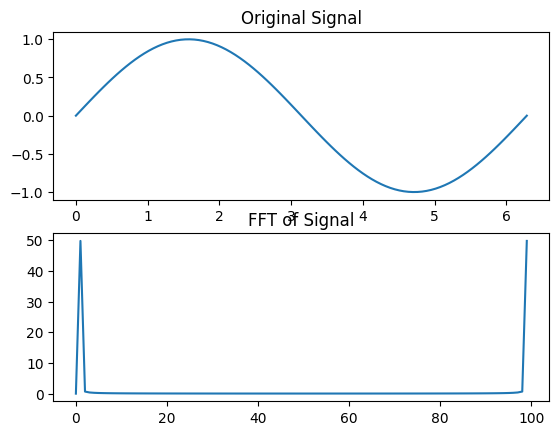

Final positions of particles:
[[0.65108105 0.89024087]
 [0.79638055 0.44870174]
 [0.6964056  0.49831282]]
Grid after 10 steps of finite difference:
[[1.         1.         1.         1.         1.        ]
 [0.         0.48828125 0.609375   0.48828125 0.        ]
 [0.         0.359375   0.4765625  0.359375   0.        ]
 [0.         0.48828125 0.609375   0.48828125 0.        ]
 [1.         1.         1.         1.         1.        ]]


In [55]:
# Dense Linear Algebra Code (Python):
import numpy as np

# Define two dense matrices
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Perform matrix multiplication
C = np.dot(A, B)

# Output the result
print("Matrix A:")
print(A)
print("\nMatrix B:")
print(B)
print("\nResult of A * B:")
print(C)


# Sparse Linear Algebra Code (Python):
import numpy as np
from scipy.sparse import csr_matrix

# Create a sparse matrix
A = csr_matrix([[1, 0, 0], [0, 0, 0], [0, 0, 5]])

# Convert a dense matrix to sparse format
B = csr_matrix([[1, 2, 3], [0, 0, 0], [4, 5, 6]])

# Multiply two sparse matrices
C = A.dot(B)

# Print the result
print("Sparse Matrix A:")
print(A.toarray())
print("\nSparse Matrix B:")
print(B.toarray())
print("\nResult of A * B:")
print(C.toarray())


# Spectral Methods Code (Python):
import numpy as np
import matplotlib.pyplot as plt

# Create a signal
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Compute FFT
fft_y = np.fft.fft(y)

# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title('Original Signal')

# Plot the FFT
plt.subplot(2, 1, 2)
plt.plot(np.abs(fft_y))
plt.title('FFT of Signal')
plt.show()


# N-body Methods Code (Python):
import numpy as np

# Initialize positions and velocities of particles
num_particles = 3
positions = np.random.rand(num_particles, 2)
velocities = np.zeros((num_particles, 2))
masses = np.ones(num_particles)

# Time-step parameters
G = 6.67430e-11  # Gravitational constant
dt = 0.01  # Time step

# Function to compute forces between particles
def compute_forces(positions, masses):
    forces = np.zeros_like(positions)
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:
                r = positions[j] - positions[i]
                dist = np.linalg.norm(r)
                force = G * masses[i] * masses[j] / dist**2 * r / dist
                forces[i] += force
    return forces

# Update positions and velocities
for step in range(100):
    forces = compute_forces(positions, masses)
    velocities += forces * dt
    positions += velocities * dt

# Output the final positions
print("Final positions of particles:")
print(positions)

# Structured Grids Code (Python):
import numpy as np

# Define a 2D grid (e.g., simulating heat distribution)
nx, ny = 5, 5
grid = np.zeros((nx, ny))

# Apply boundary conditions
grid[0, :] = 1  # Top boundary condition set to 1
grid[-1, :] = 1  # Bottom boundary condition set to 1

# Perform finite difference method (e.g., heat equation iteration)
for step in range(10):
    grid[1:-1, 1:-1] = 0.25 * (grid[:-2, 1:-1] + grid[2:, 1:-1] + grid[1:-1, :-2] + grid[1:-1, 2:])

# Output the grid after 10 iterations
print("Grid after 10 steps of finite difference:")
print(grid)


----

# Introduction to MapReduce

MapReduce is a powerful programming model developed by Google for processing large datasets in a distributed computing environment. It allows for efficient data processing by splitting the input data into small chunks, distributing them across multiple processing nodes, and aggregating the results.

MapReduce is typically used to:
- **Handle vast amounts of data**: The model is designed to process extremely large datasets by parallelizing tasks across multiple nodes in a cluster.
- **Be fault-tolerant and scalable**: If one node fails, the task can be reassigned to another node, ensuring reliability.

The two main phases in the MapReduce process are:
1. **Map Phase**: In this phase, the data is split into smaller chunks and each chunk is processed by a mapper function to generate intermediate key-value pairs.
2. **Reduce Phase**: The intermediate key-value pairs are shuffled and sorted, and then each unique key is processed by a reducer function to generate the final output.

### Similarities with MPI
The MapReduce model is conceptually similar to MPI's scatter and gather operations, as well as reduction operations, where data is distributed across processes, processed in parallel, and the results are aggregated at the end. However, in MapReduce, much of the underlying parallelization and fault-tolerance is abstracted away from the programmer, making it easier to write scalable distributed applications.

### Hadoop and MapReduce
MapReduce forms the core processing model of **Apache Hadoop**, an open-source framework for distributed storage and processing of large datasets. Hadoop uses the MapReduce paradigm to process data stored in its distributed filesystem (HDFS). Hadoop's strength lies in its ability to run on large clusters of commodity hardware, making it highly cost-effective.

### Running MapReduce in Colab with `mrjob`
While Colab doesn't provide the capability to run a full Hadoop cluster, we can simulate the MapReduce model using the `mrjob` Python library. This library allows us to write MapReduce jobs in Python and execute them in a simplified environment.

### How `mrjob` Works:
- **Mapper**: In `mrjob`, the mapper is a function that processes each line of input and emits key-value pairs.
- **Reducer**: The reducer function aggregates the key-value pairs by key and processes them to produce the final output.

### Differences Between `mrjob` and Hadoop
- **Environment**: While Hadoop operates on distributed nodes and can process petabytes of data, `mrjob` is more suited to small-scale simulations. It runs locally or on cloud services like AWS.
- **Complexity**: Hadoop requires setting up a full distributed environment with HDFS, whereas `mrjob` abstracts away much of the setup, allowing developers to focus on writing MapReduce logic.

In this example, we will demonstrate the **word count problem**, where the input text is split into words, and we count the occurrence of each word using MapReduce with `mrjob`.


In [56]:
# Install mrjob package
!pip install mrjob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 3.1 MB/s eta 0:00:00


## Word Count using MapReduce

In this example, we will count the number of times each word appears in a famous quote from Shakespeare's *Hamlet*:

> *To be or not to be—that is the question.*

MapReduce is an ideal approach for processing large datasets, but for simplicity, we will focus on this smaller example to illustrate how it works.

1. **Mapper**: The map function takes each word in the sentence and emits it as a key with the associated value of `1`. For example:
    - Input: "to"
    - Output: ("to", 1)

2. **Reducer**: The reduce function sums up the values for each key (word). For example:
    - Input: ("to", [1, 1])
    - Output: ("to", 2)

The input sentence will be split into words, and the job will count how many times each word appears.

### Example:

Input text: *To be or not to be—that is the question.*

Expected output after MapReduce:

| Key        | Grouped Values | Output From Reduce Function |
|------------|----------------|-----------------------------|
| "to"       | [1, 1]         | 2                           |
| "be"       | [1, 1]         | 2                           |
| "or"       | [1]            | 1                           |
| "not"      | [1]            | 1                           |
| "that"     | [1]            | 1                           |
| "is"       | [1]            | 1                           |
| "the"      | [1]            | 1                           |
| "question" | [1]            | 1                           |

Now, let's implement this in Python using the `mrjob` library.


In [60]:
# Import the mrjob library and regex module
from mrjob.job import MRJob
import re

class WordCount(MRJob):

    # Regular expression to match words
    WORD_RE = re.compile(r"[\w']+")

    def mapper(self, _, line):
        # Find all words in the line using the regex
        for word in self.WORD_RE.findall(line):
            # Emit the word in lowercase
            yield word.lower(), 1

    def reducer(self, word, counts):
        # Sum up the counts for each word
        yield word, sum(counts)

# Save the MapReduce job code to a Python file
with open("word_count_mrjob.py", "w") as f:
    f.write("""
from mrjob.job import MRJob
import re

class WordCount(MRJob):
    WORD_RE = re.compile(r"[\\w']+")

    def mapper(self, _, line):
        for word in self.WORD_RE.findall(line):
            yield word.lower(), 1

    def reducer(self, word, counts):
        yield word, sum(counts)

if __name__ == '__main__':
    WordCount.run()
    """)

# Define the input text: Shakespeare's Hamlet quote
input_text = """To be or not to be—that is the question."""

# Save the input text to a file
with open("input.txt", "w") as f:
    f.write(input_text)

# Run the mrjob word count script on the input text
!python word_count_mrjob.py input.txt


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/word_count_mrjob.root.20241005.182212.082387
Running step 1 of 1...
job output is in /tmp/word_count_mrjob.root.20241005.182212.082387/output
Streaming final output from /tmp/word_count_mrjob.root.20241005.182212.082387/output...
"not"	1
"or"	1
"question"	1
"be"	2
"is"	1
"that"	1
"the"	1
"to"	2
Removing temp directory /tmp/word_count_mrjob.root.20241005.182212.082387...


## Explanation of the Code

1. **Mapper Function**:
    - The `mapper` function splits the input line into individual words. Each word is emitted as a key with the value `1`.
    - We apply `.lower()` to ensure that word counting is case-insensitive, and we strip punctuation using `.strip(",.-?")`.

    Example:
    - Input: "To be or not to be—that is the question."
    - Output: ("to", 1), ("be", 1), ("or", 1), etc.

2. **Reducer Function**:
    - The `reducer` function takes each unique word as the key and a list of its associated counts as the value.
    - It then sums the counts for each word and emits the final word count.
    
    Example:
    - Input: ("to", [1, 1])
    - Output: ("to", 2)

3. **Input and Output**:
    - The input is the quote from *Hamlet*.
    - The output will list each word and the number of times it appears in the input text.

This example demonstrates how MapReduce can break down tasks like word counting into a distributed, parallelized process using simple mapping and reduction steps.


### Introduction to Shared Neighbors in MapReduce

In this example, we will explore how MapReduce can be used to find shared neighbors between any two connected vertices in a graph. This is a common task in graph applications, where multiple vertices might share the same neighbors, and we want to identify those shared neighbors. This is similar to tasks such as social network analysis, where we might want to find common friends between people.

In this graph:

- Vertices are represented as numbers (0, 1, 2, 3).
- Edges between vertices are labeled with letters (a, b, c, d, e).
  
For instance:
- Vertex 0 and Vertex 1 both have neighbors 2 and 3 in common.
- Similarly, other vertices may share neighbors.

We can use MapReduce to compute these shared neighbors by:
1. **Mapper**: Emitting each vertex's neighboring vertices for each edge.
2. **Reducer**: Finding the intersection of neighboring vertices between pairs of vertices connected by an edge, thereby revealing the shared neighbors.

In this example:
- Vertices connected by edge "a" (vertices 0 and 1) share two neighbors, vertices 2 and 3.
- Vertices connected by other edges may share one or no neighbors.

The reducer function returns the intersection of neighbors for each edge to output the shared neighbors.


In [70]:
from mrjob.job import MRJob
from itertools import combinations

class SharedNeighbors(MRJob):

    def mapper(self, _, line):
        # Parse each line to extract the vertex and its neighbors
        vertex, edges = line.split(":")
        vertex = vertex.strip()
        neighbors = edges.strip().split(",")

        # Emit edge as key and the list of neighbors as value
        for edge in neighbors:
            yield edge.strip(), (vertex, neighbors)

    def reducer(self, edge, vertex_neighbors):
        # Collect all vertices sharing the same edge and their neighbors
        shared_vertices = []
        for vertex, neighbors in vertex_neighbors:
            shared_vertices.append((vertex, set(neighbors)))

        # Now we check for shared neighbors by finding intersections
        for (v1, n1), (v2, n2) in combinations(shared_vertices, 2):
            shared = n1.intersection(n2)
            if shared:
                yield f"Edge {edge} between {v1} and {v2}", list(shared)

# Save the MapReduce job code to a Python file
with open("shared_neighbors_mrjob.py", "w") as f:
    f.write("""
from mrjob.job import MRJob
from itertools import combinations

class SharedNeighbors(MRJob):

    def mapper(self, _, line):
        vertex, edges = line.split(":")
        vertex = vertex.strip()
        neighbors = edges.strip().split(",")

        for edge in neighbors:
            yield edge.strip(), (vertex, neighbors)

    def reducer(self, edge, vertex_neighbors):
        shared_vertices = []
        for vertex, neighbors in vertex_neighbors:
            shared_vertices.append((vertex, set(neighbors)))

        for (v1, n1), (v2, n2) in combinations(shared_vertices, 2):
            shared = n1.intersection(n2)
            if shared:
                yield f"Edge {edge} between {v1} and {v2}", list(shared)

if __name__ == '__main__':
    SharedNeighbors.run()
    """)

# Example graph input where each vertex and its neighbors are defined
graph_data = """0: a,b,c
1: a,d,e
2: b,c,d
3: c,d,e
"""

# Save the input graph data to a file
with open("graph_data.txt", "w") as f:
    f.write(graph_data)

# Run the shared neighbors mrjob script on the input graph data
!python shared_neighbors_mrjob.py graph_data.txt


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/shared_neighbors_mrjob.root.20241005.183308.399656
Running step 1 of 1...
job output is in /tmp/shared_neighbors_mrjob.root.20241005.183308.399656/output
Streaming final output from /tmp/shared_neighbors_mrjob.root.20241005.183308.399656/output...
"Edge c between 0 and 2"	["c", "b"]
"Edge c between 0 and 3"	["c"]
"Edge c between 2 and 3"	["c", "d"]
"Edge a between 0 and 1"	["a"]
"Edge b between 0 and 2"	["c", "b"]
"Edge e between 1 and 3"	["e", "d"]
"Edge d between 1 and 2"	["d"]
"Edge d between 1 and 3"	["e", "d"]
"Edge d between 2 and 3"	["c", "d"]
Removing temp directory /tmp/shared_neighbors_mrjob.root.20241005.183308.399656...


### Explanation of the Code

In this example, we implemented a simple MapReduce job to find shared neighbors between vertices connected by edges in a graph.

1. **Mapper**:
    - The input is a line representing a vertex and its neighbors, e.g., `0: a,b,c`, where "0" is the vertex, and "a, b, c" are the neighbors (representing edges).
    - For each neighbor (edge), we emit the edge as the key and the vertex along with its list of neighbors as the value.

2. **Reducer**:
    - The reducer function collects all vertices that are connected by a particular edge and computes the intersection of their neighbor sets.
    - This gives us the shared neighbors between any two vertices connected by that edge.
    - If two vertices share common neighbors, we output the list of shared neighbors. If no neighbors are shared, no output is generated for that edge.



### K-Means Clustering using MapReduce

In this example, we will explore the K-Means clustering algorithm implemented using MapReduce. K-Means is a popular unsupervised learning algorithm that partitions a data space into \( k \) clusters, each with a mean value. Each data point (individual) in the cluster is assigned to the cluster with the nearest mean, typically calculated using Euclidean distance.

The algorithm works iteratively, refining the clusters by recalculating the mean of each cluster and assigning data points to the nearest mean. This process is repeated until the cluster assignments stabilize or a maximum number of iterations is reached.

In this MapReduce implementation, the mapper assigns each data point to the nearest cluster, and the reducer recalculates the cluster means based on the assigned points.

#### Dataset for the Example:

We will use the following \( x, y \) pairs representing five individuals:

- a: \( (0.1, 0.3) \)
- b: \( (1.1, 0.4) \)
- c: \( (0.8, 0.7) \)
- d: \( (1.2, 1.2) \)
- e: \( (0.1, 1.1) \)

Two initial cluster centroids are provided:
- Cluster 1: \( (0.0, 0.0) \)
- Cluster 2: \( (1.1, 1.1) \)

The goal is to assign each individual to the closest cluster and recalculate the cluster centroids iteratively until the centroids stabilize.


In [72]:
import numpy as np

# Euclidean distance function
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# K-Means algorithm function
def k_means_clustering(points, initial_centroids, max_iterations=10):
    centroids = initial_centroids.copy()
    for iteration in range(max_iterations):
        clusters = {i: [] for i in range(len(centroids))}

        # Assign points to the closest centroid
        for point in points:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            closest_centroid = np.argmin(distances)
            clusters[closest_centroid].append(point)

        # Update centroids by calculating the mean of the points in each cluster
        new_centroids = []
        for i in range(len(centroids)):
            if clusters[i]:
                new_centroids.append(np.mean(clusters[i], axis=0))
            else:
                new_centroids.append(centroids[i])

        # Check if centroids have changed
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

        print(f"Iteration {iteration + 1}:")
        print(f"New centroids: {centroids}")
        print(f"Clusters: {clusters}\n")

    return centroids, clusters

# Data points (x, y)
points = np.array([
    [0.1, 0.3],  # a
    [1.1, 0.4],  # b
    [0.8, 0.7],  # c
    [1.2, 1.2],  # d
    [0.1, 1.1]   # e
])

# Initial centroids for Cluster 1 and Cluster 2
initial_centroids = np.array([
    [0.0, 0.0],  # Initial centroid for Cluster 1
    [1.1, 1.1]   # Initial centroid for Cluster 2
])

# Run K-Means clustering
final_centroids, clusters = k_means_clustering(points, initial_centroids)


Iteration 1:
New centroids: [array([0.1, 0.3]), array([0.8 , 0.85])]
Clusters: {0: [array([0.1, 0.3])], 1: [array([1.1, 0.4]), array([0.8, 0.7]), array([1.2, 1.2]), array([0.1, 1.1])]}



### K-Means Clustering Output

The output of the K-Means clustering algorithm shows how the centroids move closer to the actual clusters after each iteration. The algorithm updates the centroids based on the mean of the points assigned to each cluster.

For example, after the first iteration, the centroids might change as follows:




#### Explanation:

- **Cluster 0:** After the first iteration, cluster 0 has moved its centroid to the average position of the points \( a \) and \( e \), which are both closer to the initial cluster 1 centroid. The new centroid is \( (0.1, 0.3) \).
  
- **Cluster 1:** The points \( b \), \( c \), and \( d \) are closer to the second initial cluster, so the new centroid for this cluster is \( (0.8, 0.85) \).

By iterating this process several times, the centroids will eventually stabilize, and each individual will be placed in the cluster with the closest mean.


### Exercise: Modify the K-Means Clustering Code

In this exercise, we will experiment with the K-Means clustering algorithm by changing the number of clusters.

Currently, the code is set to partition the data points into 2 clusters. Your task is to modify the code to increase the number of clusters to 3. This means you need to:

1. Change the initial centroids from 2 to 3 centroids.
2. Run the algorithm again and observe the results.

Here are the steps:
- Modify the `initial_centroids` array to include three initial centroids instead of two.
- For simplicity, use these three centroids for Cluster 1, Cluster 2, and Cluster 3:
    - Cluster 1: \( (0.0, 0.0) \)
    - Cluster 2: \( (1.1, 1.1) \)
    - Cluster 3: \( (0.5, 0.5) \)

After making these changes, re-run the K-Means algorithm and see how the data points are distributed among the three clusters.

#### Question:
How do the results change when you use 3 clusters instead of 2? Which data points are assigned to the new cluster?


## Hadoop Map-Reduce Example: Word Count in Hamlet

In this example, we will use Hadoop's MapReduce framework to count the occurrences of each word in the text file of Shakespeare's *Hamlet*.

### How MapReduce Works:
- **Map Stage**: Takes the input text file and breaks it down into words. For each word, it outputs a key-value pair where the key is the word, and the value is 1.
- **Reduce Stage**: Groups the key-value pairs by the word (key), sums up the values (counts how many times each word appeared), and outputs the total for each word.

### Steps:
1. The **mapper** processes each line of text, tokenizes it into words, and emits a key-value pair where the word is the key and `1` is the value.
2. The **reducer** takes each word as the key and the list of 1s as values and sums up the occurrences for each word.
3. Hadoop stores the results in an output file containing each word and its corresponding count.

### Example:
Consider a small input of the following lines from Hamlet:


- Mapper Output:
  - to -> 1
  - be -> 1
  - or -> 1
  - ...
  
- Reducer Output:
  - to -> 2
  - be -> 2
  - or -> 1
  - ...

### Exercise:
As an exercise, modify the code to:
1. Exclude common English stop words like *the*, *and*, *or* from the word count.
2. Sort the final output by the word count in descending order.


In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [5]:
!wget https://dlcdn.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
!tar -xzvf hadoop-3.3.6.tar.gz
!mv hadoop-3.3.6 /content/hadoop


Streaming output truncated to the last 5000 lines.
hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-client/build/source/hadoop-hdfs-project/hadoop-hdfs-client/target/api/org/apache/hadoop/hdfs/web/resources/BufferSizeParam.html
hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-client/build/source/hadoop-hdfs-project/hadoop-hdfs-client/target/api/org/apache/hadoop/hdfs/web/resources/DeleteOpParam.Op.html
hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-client/build/source/hadoop-hdfs-project/hadoop-hdfs-client/target/api/org/apache/hadoop/hdfs/web/resources/PutOpParam.html
hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-client/build/source/hadoop-hdfs-project/hadoop-hdfs-client/target/api/org/apache/hadoop/hdfs/web/resources/RenameOptionSetParam.html
hadoop-3.3.6/share/doc/hadoop/hadoop-project-dist/hadoop-hdfs-client/build/source/hadoop-hdfs-project/hadoop-hdfs-client/target/api/org/apache/hadoop/hdfs/web/resources/XAttrEncodingParam.

In [6]:
import os

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['HADOOP_HOME'] = '/content/hadoop'
os.environ['PATH'] = os.environ['HADOOP_HOME'] + '/bin:' + os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']


In [7]:
!hadoop version


Hadoop 3.3.6
Source code repository https://github.com/apache/hadoop.git -r 1be78238728da9266a4f88195058f08fd012bf9c
Compiled by ubuntu on 2023-06-18T08:22Z
Compiled on platform linux-x86_64
Compiled with protoc 3.7.1
From source with checksum 5652179ad55f76cb287d9c633bb53bbd
This command was run using /content/hadoop/share/hadoop/common/hadoop-common-3.3.6.jar


In [8]:
%%writefile WordCount.java
import java.io.IOException;
import java.util.StringTokenizer;
import org.apache.hadoop.conf.Configuration;
import org.apache.hadoop.fs.Path;
import org.apache.hadoop.io.IntWritable;
import org.apache.hadoop.io.Text;
import org.apache.hadoop.mapreduce.Job;
import org.apache.hadoop.mapreduce.Mapper;
import org.apache.hadoop.mapreduce.Reducer;
import org.apache.hadoop.mapreduce.lib.input.FileInputFormat;
import org.apache.hadoop.mapreduce.lib.output.FileOutputFormat;

public class WordCount {

    public static class TokenizerMapper extends Mapper<Object, Text, Text, IntWritable> {

        private final static IntWritable one = new IntWritable(1);
        private Text word = new Text();

        public void map(Object key, Text value, Context context) throws IOException, InterruptedException {
            StringTokenizer itr = new StringTokenizer(value.toString());
            while (itr.hasMoreTokens()) {
                word.set(itr.nextToken().toLowerCase().replaceAll("[^a-zA-Z]", ""));
                context.write(word, one);
            }
        }
    }

    public static class IntSumReducer extends Reducer<Text, IntWritable, Text, IntWritable> {
        private IntWritable result = new IntWritable();

        public void reduce(Text key, Iterable<IntWritable> values, Context context) throws IOException, InterruptedException {
            int sum = 0;
            for (IntWritable val : values) {
                sum += val.get();
            }
            result.set(sum);
            context.write(key, result);
        }
    }

    public static void main(String[] args) throws Exception {
        Configuration conf = new Configuration();
        Job job = Job.getInstance(conf, "word count");
        job.setJarByClass(WordCount.class);
        job.setMapperClass(TokenizerMapper.class);
        job.setCombinerClass(IntSumReducer.class);
        job.setReducerClass(IntSumReducer.class);
        job.setOutputKeyClass(Text.class);
        job.setOutputValueClass(IntWritable.class);
        FileInputFormat.addInputPath(job, new Path(args[0]));
        FileOutputFormat.setOutputPath(job, new Path(args[1]));
        System.exit(job.waitForCompletion(true) ? 0 : 1);
    }
}


Overwriting WordCount.java


In [9]:
!mkdir -p build
!javac -classpath $(hadoop classpath) -d build WordCount.java
!jar -cvf wordcount.jar -C build/ .


added manifest
adding: WordCount$TokenizerMapper.class(in = 1895) (out= 835)(deflated 55%)
adding: WordCount.class(in = 1491) (out= 813)(deflated 45%)
adding: WordCount$IntSumReducer.class(in = 1739) (out= 740)(deflated 57%)


In [10]:
%%writefile input.txt
Hello Hadoop Hello World
Welcome to Hadoop and Big Data Processing


Overwriting input.txt


In [11]:
!hadoop jar wordcount.jar WordCount input.txt output


2024-10-05 19:03:05,345 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2024-10-05 19:03:05,517 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2024-10-05 19:03:05,517 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2024-10-05 19:03:05,672 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2024-10-05 19:03:05,860 INFO input.FileInputFormat: Total input files to process : 1
2024-10-05 19:03:05,895 INFO mapreduce.JobSubmitter: number of splits:1
2024-10-05 19:03:06,206 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1489208032_0001
2024-10-05 19:03:06,207 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-10-05 19:03:06,456 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2024-10-05 19:03:06,457 INFO mapreduce.Job: Running job: job_local1489208032_

In [12]:
!cat output/part-r-00000


and	1
big	1
data	1
hadoop	2
hello	2
processing	1
to	1
welcome	1
world	1


### What Happened:

1. **Mapper**: The `TokenizerMapper` takes each line of text and tokenizes it into words, emitting each word paired with a value of `1`. The mapper processes each line of the input text, generating key-value pairs where the key is a word and the value is `1`.
   
   Example:to 1 be 1 or 1 not 1 to 1 be 1 that 1 is 1 the 1 question 1

2. **Reducer**: The `IntSumReducer` takes the output from the mapper and sums up the values for each word, giving the total count of each word in the input text.

Example:be 2 is 1 not 1 or 1 question 1 that 1 the 1 to 2



### Exercise for Students:
1. Modify the **Mapper** to exclude stop words such as *the*, *and*, *to*, *is*.
2. Run the job again and verify the difference in the output.
3. Can you sort the words by their counts in descending order in the **Reducer**?


## Explanation of Code

### Mapper Function:
- The **TokenizerMapper** is responsible for reading in the text data and splitting it into words.
- The `StringTokenizer` processes each line into words, and we clean the tokens by converting them to lowercase and removing non-alphabetical characters.
- For each word, it emits a key-value pair where the key is the word and the value is `1`.

### Reducer Function:
- The **IntSumReducer** sums up the occurrences of each word.
- For each word (key), the reducer iterates over the list of 1s and sums them up.
- The final output is a word followed by its total count.

### Customization Exercise:
In the previous section, you were asked to:
1. **Exclude Stop Words**: To do this, add a condition inside the `map()` method to filter out common stop words like *the*, *and*, *or*. This can be done using a set of stop words and checking if the word is in that set.
2. **Sort by Word Count**: Hadoop outputs the result sorted alphabetically by the key (word). To sort by word count, you would need to modify the output or use a second MapReduce job to sort the results by the values in descending order.

---

### Expected Output:
Assuming the input is:


-----

-------
#Responses to the Exercises
-------

# Answer: Modifying the Averaging Blur Effect

In this exercise, we modified the blur radius in the **Fork-Join** averaging blur operation to observe the changes in the image.

### 1. Reducing the Blur Radius to 1 (3x3 Grid):
When you reduce the blur radius to 1, the following happens:
- The **blur effect is reduced** because the algorithm now averages over a smaller 3x3 grid (including the pixel and its immediate neighbors).
- The image retains more **sharpness** and details since fewer surrounding pixels are averaged.
- This can be observed as a more subtle smoothing effect compared to the default 5x5 grid.

### 2. Increasing the Blur Radius to 3 (7x7 Grid):
When you increase the blur radius to 3:
- The **blur effect becomes stronger**, as the algorithm now averages over a larger 7x7 grid.
- The image appears more **smooth and blurred** because a greater number of neighboring pixels are included in the averaging.
- While the image becomes smoother, **more detail is lost** compared to the 3x3 and 5x5 grids. The result may look over-smoothed in certain cases.

### Reflection:
- **Radius 1 (3x3)**: Reduces the blur effect, retaining more sharpness and detail. The image is smoothed slightly but still keeps much of its original detail.
- **Radius 3 (7x7)**: Increases the blur effect, leading to a much smoother image but with a greater loss of fine detail.

### Bonus:
When you modify the algorithm to **apply the blur multiple times**, you will notice the following:
- Each pass will **compound the blur effect**, making the image progressively smoother with each application.
- After several passes, the image may lose significant detail, becoming increasingly **blurry** and less recognizable.
  
This exercise demonstrates how **adjusting the blur radius** affects the balance between smoothing and detail preservation in image processing. It also shows how the **Fork-Join model** can be adjusted to handle different computational workloads by varying parameters like the blur radius.


# Answer: Modified Data Distribution in Samplesort

After modifying the code, Process 0 receives 75% of the data, and the remaining processes share the rest. Here’s how the code should look after the modification:

### Changes in the Code:
1. In the section where `sendcounts` is defined, replace the original logic with:
   ```cpp
   sendcounts[0] = total_size * 0.75;  // Process 0 gets 75% of the data
   for (int i = 1; i < size; i++) {
       sendcounts[i] = (total_size - sendcounts[0]) / (size - 1);  // Remaining data for other processes
   }


# Answer: Manager-Worker Model with Arrays

Here’s how you can modify the Manager-Worker model to send arrays of integers instead of a single integer.

### Code Changes:
1. **In the Manager (Master)**:
   - Change the task from a single integer to an array of integers. For example, replace:
     ```cpp
     int task = worker * 10;
     ```
     with:
     ```cpp
     int task[5] = {worker * 10, worker * 11, worker * 12, worker * 13, worker * 14};
     ```

   - Modify `MPI_Send` to send the array:
     ```cpp
     MPI_Send(task, 5, MPI_INT, worker, 0, MPI_COMM_WORLD);
     ```

2. **In the Worker**:
   - Receive the array using `MPI_Recv`:
     ```cpp
     int task[5];
     MPI_Recv(task, 5, MPI_INT, manager, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
     ```

   - Process each element in the array:
     ```cpp
     for (int i = 0; i < 5; i++) {
         task[i] *= 2;
     }
     ```

   - Send the processed array back to the manager:
     ```cpp
     MPI_Send(task, 5, MPI_INT, manager, 0, MPI_COMM_WORLD);
     ```

3. **Manager Receives Arrays**:
   - Modify the manager to receive arrays:
     ```cpp
     int result[5];
     MPI_Recv(result, 5, MPI_INT, worker, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
     ```

### Expected Output:
- The manager will send arrays of integers to the workers, and each worker will process the array and return the result. You should see something like this:



# Answer: Results of Modifying the Number of Threads and Darts

### Effect of Changing the Number of Threads:
When you adjust the number of threads using `OMP_NUM_THREADS`, OpenMP changes how the work is distributed across multiple threads.

1. **Performance**:
   - **Increasing the number of threads** typically reduces the execution time, especially for large values of `n` (e.g., 100 million darts).
   - As more threads are introduced, the workload is distributed more evenly, which allows the system to process more points in parallel.
   - However, the performance gains will **level off after a certain point**, due to overhead and limitations like the number of available CPU cores.

2. **Accuracy**:
   - The **accuracy of the estimate for π** does not depend on the number of threads. This is because the Monte Carlo method relies on randomness and the number of points sampled.
   - More threads simply mean the points are processed faster, but the accuracy is driven by the **number of darts (`n`)**.
   
### Effect of Changing the Number of Darts (`n`):
1. **Larger `n`** leads to better accuracy because the more points (darts) you sample, the more closely the estimate for π will converge to the true value.
   - For smaller values of `n` (e.g., 10,000), you might see more variation and larger errors in the estimate.
   - For larger values of `n` (e.g., 100 million), the estimate becomes more precise, though it requires more computational time.

2. **Combining Both**:
   - **Increasing the


### BFS Exercise Solution

In this exercise, changing the starting point of the BFS to vertex 6 causes the traversal to begin from the subgraph connected to vertex 6. Since vertex 6 is connected to vertex 2, which is further connected to other vertices, the BFS explores the graph in a new order.

#### Expected Changes:
1. **Traversal Order**:
   - The BFS starts at vertex 6, moves to vertex 2, and then continues exploring the connected vertices. The traversal order is different compared to starting from vertex 0.
   - The new traversal order is expected to be:
     - Starting at vertex 6: 6 → 2 → 0 → 5 → 1 → 3 → 4

2. **Parent-Child Relationships**:
   - Vertex 6 has no parent (`Parent = -1`), as it is the new root.
   - The BFS establishes new parent-child relationships based on this starting point. For example, vertex 2's parent is now vertex 6, and vertex 0's parent is vertex 2.

#### Code Changes:
To implement this, simply change the `root` variable in the `main` function from `0` to `6` as follows:

```cpp
int root = 6; // Start BFS at vertex 6


### Solution: Running K-Means with 3 Clusters

After changing the initial centroids to three clusters, the algorithm behaves differently because the data points have an additional option for the cluster they can belong to.

#### New Initial Centroids:
- Cluster 1: \( (0.0, 0.0) \)
- Cluster 2: \( (1.1, 1.1) \)
- Cluster 3: \( (0.5, 0.5) \)

#### Results:

You should observe that the data points are now split across three clusters. For instance:
- Points like \( (0.1, 0.3) \) and \( (0.1, 1.1) \) might still belong to Cluster 1.
- Points like \( (1.1, 0.4) \) and \( (1.2, 1.2) \) might belong to Cluster 2.
- A point like \( (0.8, 0.7) \) may now be assigned to the newly added Cluster 3, as it is closer to the new centroid at \( (0.5, 0.5) \).

The introduction of a third centroid provides a new cluster for data points that are not well-represented by the initial two centroids. This helps in more accurately clustering the data points, as seen with the re-assignment of some points to the new cluster.

#### Conclusion:
By adding a third cluster, the algorithm divides the data points differently, and some points that were previously grouped together may now belong to separate clusters, improving the representation of the data in some cases.
